# ¿Por qué funciona CountVectorizer para "Identificar" noticias falsas?

### Librerias Usadas.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec
from scipy.sparse import csr_matrix, hstack
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import tensorflow as tf
import re, string, nltk
from matplotlib_venn import venn2

# Descarga de recursos
nltk.download("wordnet")
nltk.download("punkt")
tf.test.gpu_device_name()

2023-06-08 22:41:19.642721: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 22:41:19.645952: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 22:41:19.691137: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 22:41:19.691918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 22:41:20.320194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

''

## Lectura de los datos


In [2]:
COLAB = False
if COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    dataFake = pd.read_csv("/content/drive/MyDrive/Fake.csv")
    dataTrue = pd.read_csv("/content/drive/MyDrive/True.csv")
else:
    dataFake = pd.read_csv("Fake.csv")
    dataTrue = pd.read_csv("True.csv")


In [3]:
dataFake["class"] = 0
print("Fake: ", dataFake.shape)

dataTrue["class"] = 1
print("True: ", dataTrue.shape)

data_merge = pd.concat([dataFake, dataTrue], axis=0)
data = data_merge.drop(["title", "subject", "date"], axis=1)
print("All data: ", data.shape)


Fake:  (23481, 5)
True:  (21417, 5)
All data:  (44898, 2)


## Preparación de los datos (como en la entrega)

Se utiliza la misma limpieza que en el trabajo entregado. Aquí solo se considerará la vectorización con CountVectorizer

In [4]:
"""
  Función que elimina los símbolos especiales de un texto,
  así como las stopwords
"""


def word_cleaner(text):
    text = text.lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("\\W", " ", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    return remove_stopwords(text)


"""
  Función que dado un texto, lo limpia y elimina las letras aisladas existentes.
"""


def text_cleaner(text, lemmatizer):
    text = word_cleaner(text)
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = remove_letters(lemmatized_tokens)
    text = " ".join(text)
    return text


"""
  Funcion que elimina las palabras con lengitud menor a length
"""


def remove_letters(lemas, length=2):
    return [word for word in lemas if len(word) > length]


"""
  Funcion que cuenta la frecuencia de palabras en el dataset
"""


def count_tokens(texts, wf):
    for text in texts:
        tokens = text.split()
        wf.update(tokens)
    return wf


"""
  Funcion que dado el dataset y la lista de palabras que no tienen una 
  frecuencua valida las elimina del dataset
"""


def remove_max_min_words_freq(texts, words_to_remove):
    filtered_texts = []
    for text in texts:
        tokens = text.split()
        filtered_tokens = [word for word in tokens if word not in words_to_remove]
        filtered_text = " ".join(filtered_tokens)
        filtered_texts.append(filtered_text)
    return filtered_texts


"""
  Funcion que obtiene la lista de palabras a eliminar
"""


def get_words_to_remove(min_freq=2, max_freq=1000, word_freq=None):
    return [
        word for word, freq in word_freq.items() if freq < min_freq or freq > max_freq
    ]


In [5]:
clean_data = data.copy()
lemmatizer = WordNetLemmatizer()
clean_data["text"] = clean_data["text"].apply(text_cleaner, args=(lemmatizer,))


In [6]:
SEED = 123456789

x = clean_data["text"]
y = clean_data["class"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=SEED
)
y_train_array = np.array(y_train)

print(f"Datos de entrenamiento: {len(x_train)} ({len(x_train)/len(x):%})")
print(f"Datos de prueba: \t{len(x_test)} ({len(x_test)/len(x):%})")


Datos de entrenamiento: 33673 (74.998886%)
Datos de prueba: 	11225 (25.001114%)


In [7]:
count_vectorizer = CountVectorizer()
x_count_train = count_vectorizer.fit_transform(x_train)
x_count_test = count_vectorizer.transform(x_test)
count_words = count_vectorizer.get_feature_names_out()


## Separación de datos por etiqueta


### Palabras en noticias falsas

In [8]:
x_count_train_fake = np.array(
    [x_count_train[i] for i in range(len(y_train_array)) if y_train_array[i] == 0]
)
x_fake_count_sum = np.array(x_count_train_fake.sum(axis=0).todense())[0]
count_fake_words = np.array(
    [count_words[i] for i in range(len(x_fake_count_sum)) if x_fake_count_sum[i] > 0]
)


### Palabras en noticias verdaderas

In [9]:
x_count_train_true = np.array(
    [x_count_train[i] for i in range(len(y_train_array)) if y_train_array[i] == 1]
)
x_true_count_sum = np.array(x_count_train_true.sum(axis=0).todense())[0]
count_true_words = np.array(
    [count_words[i] for i in range(len(x_true_count_sum)) if x_true_count_sum[i] > 0]
)

### Diferencial de apariciones

In [10]:
x_total_counts = x_true_count_sum + x_fake_count_sum
x_count_diff = x_true_count_sum - x_fake_count_sum
sorted_diff_indexes = list(range(len(x_count_diff)))
sorted_diff_indexes.sort(key=x_count_diff.__getitem__, reverse=True)

## Análisis de traslapes

### Traslape de apariciones

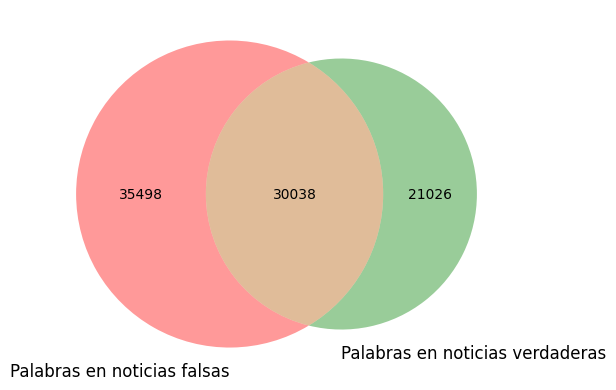

In [11]:
true_words_set = set(count_true_words)
fake_words_set = set(count_fake_words)
venn2(
    [fake_words_set, true_words_set],
    ["Palabras en noticias falsas", "Palabras en noticias verdaderas"],
)


Se observa que hay muchas palabras que solamente aparecen en un tipo de noticias. Por lo anterior, dichas palabras (dado este conjunto de entrenamiento) pueden ser utilizadas como indicadoras con mucha asertividad. Esto ni siquiera considera palabras que aparecen varias veces en un tipo de noticias y muy pocas en el otro tipo (esas palabras también sirven para diferenciar).

### Palabras más populares en cada tipo de noticias

In [12]:
sorted_fake_indexes = list(range(len(x_fake_count_sum)))
sorted_fake_indexes.sort(key=x_fake_count_sum.__getitem__, reverse=True)

n_top = 20
print("Palabras más frecuentes en noticias falsas:")
for i in sorted_fake_indexes[:n_top]:
    print(f"* {count_words[i].ljust(15)}: {x_fake_count_sum[i]}  \t({x_fake_count_sum[i]/x_total_counts[i]:%} de apariciones falsas)")

print()

sorted_true_indexes = list(range(len(x_true_count_sum)))
sorted_true_indexes.sort(key=x_true_count_sum.__getitem__, reverse=True)

n_top = 20
print("Palabras más frecuentes en noticias verdaderas:")
for i in sorted_true_indexes[:n_top]:
    print(f"* {count_words[i].ljust(15)}: {x_true_count_sum[i]}  \t({x_true_count_sum[i]/x_total_counts[i]:%} de apariciones verdaderas)")


Palabras más frecuentes en noticias falsas:
* trump          : 59612  	(58.938918% de apariciones falsas)
* said           : 25262  	(25.285769% de apariciones falsas)
* president      : 21111  	(49.407882% de apariciones falsas)
* people         : 19895  	(63.144698% de apariciones falsas)
* state          : 17768  	(38.522244% de apariciones falsas)
* clinton        : 14932  	(68.064546% de apariciones falsas)
* year           : 14463  	(45.978510% de apariciones falsas)
* time           : 14420  	(66.283613% de apariciones falsas)
* obama          : 13988  	(66.505016% de apariciones falsas)
* like           : 13821  	(79.362618% de apariciones falsas)
* american       : 13521  	(70.753532% de apariciones falsas)
* donald         : 13169  	(62.608158% de apariciones falsas)
* republican     : 12503  	(41.821648% de apariciones falsas)
* right          : 11250  	(61.647214% de apariciones falsas)
* new            : 10883  	(46.235874% de apariciones falsas)
* news           : 10774  

Se ve que, dentro de las palabras más populares, se comienzan a distinguir unas que son más populares en un tipo de noticias que en otro.

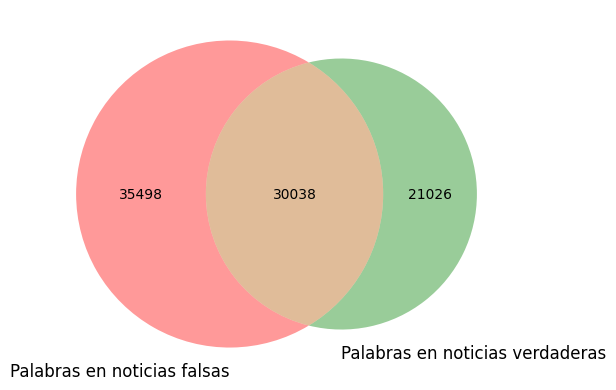

In [13]:
true_words_set = set(count_true_words)
fake_words_set = set(count_fake_words)
venn2(
    [fake_words_set, true_words_set],
    ["Palabras en noticias falsas", "Palabras en noticias verdaderas"],
)


#### Palabras con mayor diferencial de apariciones en cada tipo de noticias

Queriendo ver palabras con tazas altas de algún tipo de noticias pero evitando aquellas que tienen una taza del 100% por solamente tener pocas apariciones en pocas noticias, nos fijamos en aquellas palabras que aparecen muchas veces en un tipo de noticias, descontando las apariciones en el otro tipo.

In [14]:
print("\nPalabras con más apariciones falsas sobre verdaderas")
for i in sorted_diff_indexes[-n_top:]:
    print(f"* {count_words[i].ljust(15)}: {x_count_diff[i]}  \t({x_fake_count_sum[i]/x_total_counts[i]:%} de apariciones falsas)")

print()

print("Palabras con más apariciones verdaderas sobre falsas")
for i in sorted_diff_indexes[:n_top]:
    print(f"* {count_words[i].ljust(15)}: {x_count_diff[i]}  \t({x_true_count_sum[i]/x_total_counts[i]:%} de apariciones verdaderas)")



Palabras con más apariciones falsas sobre verdaderas
* medium         : -5300  	(71.689311% de apariciones falsas)
* donald         : -5304  	(62.608158% de apariciones falsas)
* black          : -5482  	(87.630423% de apariciones falsas)
* video          : -5977  	(88.328844% de apariciones falsas)
* woman          : -5978  	(76.022985% de apariciones falsas)
* com            : -6036  	(97.557517% de apariciones falsas)
* featured       : -6113  	(98.724693% de apariciones falsas)
* news           : -6248  	(70.418301% de apariciones falsas)
* america        : -6483  	(81.455604% de apariciones falsas)
* twitter        : -6804  	(81.800337% de apariciones falsas)
* obama          : -6943  	(66.505016% de apariciones falsas)
* time           : -7085  	(66.283613% de apariciones falsas)
* know           : -7118  	(82.454860% de apariciones falsas)
* clinton        : -7926  	(68.064546% de apariciones falsas)
* american       : -7932  	(70.753532% de apariciones falsas)
* people        

Se distingue que varias de las palabras que aparecen más en noticias falsas son nombres de políticos o partidos políticos.